In [1]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

def calculate_metrics(true_values, pred_values):
    mse = round(mean_squared_error(true_values, pred_values),3)
    mae = round(mean_absolute_error(true_values, pred_values),3)
    r_score = round(r2_score(true_values, pred_values),3)

    return {"mse": mse,
            "mae": mae,
            "r^2": r_score,}

In [2]:
import h2o
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 21.0.1+12-LTS-29, mixed mode, sharing)
  Starting server from C:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\38066\AppData\Local\Temp\tmp5u74alqm
  JVM stdout: C:\Users\38066\AppData\Local\Temp\tmp5u74alqm\h2o_38066_started_from_python.out
  JVM stderr: C:\Users\38066\AppData\Local\Temp\tmp5u74alqm\h2o_38066_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Kiev
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,4 months and 18 days
H2O_cluster_name:,H2O_from_python_38066_1atcd9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.952 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [4]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_pKa_07.05_v5_canonical_smiles.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index_canon_smiles.pkl'

dataPreparation = DataPreparation(CSV_PATH)

outliers_features_to_skip = ['dipole_moment', 'distance_between_atoms_in_f_group_centers']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=True,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=False,
                                           outliers_features_to_skip=outliers_features_to_skip,
                                           is_convert_angles_to_category=True)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features:
        features_to_drop.append(feature_name)
    elif "ring" in feature_name.lower() and feature_name not in ring_features_to_remain:
        features_to_drop.append(feature_name)
    elif len(X[feature_name].unique()) == 1:
        print(f"feature without unique values: {feature_name}")
        features_to_drop.append(feature_name)
    # elif "angle" in feature_name or "distance" in feature_name:
    #     features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_column_name='Smiles',
                   smiles_filepath=smiles_filepath,
                   is_pKa=True,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

train = h2o.H2OFrame(train_df)
test = h2o.H2OFrame(test_df)

True
174
['f_to_fg', 'chirality', 'tpsa+f', 'angle_R2X2R1', 'nFARing', 'nFAHRing', 'TASA', 'nC', 'nO', 'nHRing', 'angle_X2X1R1', 'dipole_moment', 'nF', 'PPSA5', 'angle_R1X1R2', 'RPCS', 'f_atom_fraction', 'PBF', 'nFRing', 'avg_atoms_in_cycle', 'FPSA3', 'identificator', 'nARing', 'PNSA5', 'f_freedom', 'sasa', 'nN', 'GeomShapeIndex', 'angle_X1X2R2', 'mol_num_cycles', 'naRing', 'distance_between_atoms_in_cycle_and_f_group', 'distance_between_atoms_in_f_group_centers', 'mol_weight', 'nAHRing', 'cis/trans', 'dihedral_angle', 'nFHRing', 'pKa', 'logP']
f_atom_fraction outliers indexes: [117, 118, 130]
PBF outliers indexes: [39, 120]
PNSA5 outliers indexes: [36, 37]
sasa outliers indexes: [120]
mol_weight outliers indexes: [120]
logP outliers indexes: [81, 82]
Remains rows:159, amount of features: 40
133 26
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [6]:
train_df

,f_to_fg,chirality,angle_R2X2R1,TASA,nC,nO,nHRing,angle_X2X1R1,dipole_moment,nF,...,mol_num_cycles,distance_between_atoms_in_cycle_and_f_group,distance_between_atoms_in_f_group_centers,mol_weight,cis/trans,dihedral_angle,nFHRing,no angle and distance,fold_id,pKa
0,2.0,0,4.0,148.683960,7,2,0,1.0,0.364516,2,...,1,4.0,4.0,164.152,0,4.0,0,0,1,4.32
1,0.0,0,0.0,207.262101,7,2,0,0.0,0.253413,0,...,1,0.0,0.0,128.171,0,0.0,0,1,0,4.85
2,0.0,3,0.0,199.083071,7,2,0,0.0,0.244237,0,...,2,0.0,0.0,126.155,2,0.0,0,1,1,4.35
4,2.0,3,3.0,142.022776,7,2,0,3.0,0.596781,2,...,2,4.0,4.0,162.136,1,1.0,0,0,1,3.80
5,2.0,3,3.0,133.117294,7,2,0,4.0,0.443854,2,...,2,4.0,4.0,162.136,2,4.0,0,0,1,3.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,2.0,2,1.0,243.216537,4,0,0,2.0,0.609207,3,...,1,1.0,1.0,125.094,1,1.0,0,0,1,6.92
165,2.0,2,3.0,160.066358,4,0,0,2.0,0.386537,2,...,1,1.0,2.0,107.104,2,4.0,0,0,1,7.76
166,2.0,2,1.0,156.570759,4,0,0,2.0,0.528761,2,...,1,1.0,1.0,107.104,1,1.0,0,0,0,7.16
167,0.0,2,0.0,227.266770,4,0,0,0.0,0.150657,0,...,1,0.0,0.0,71.123,2,0.0,0,1,1,9.44


In [7]:
import numpy as np
import pandas as pd
import scipy.stats as ss

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


ring_features = [feature_name for feature_name in X.columns if 'ring' in feature_name.lower()]
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']

for i in range(len(ring_features)):
    for j in range(len(ring_features)):
        first_feature = X[ring_features[i]]
        second_feature = X[ring_features[j]]

        if i == j:
            continue

        confusion_matrix = pd.crosstab(first_feature, second_feature)
        cramers_v_value = cramers_v(confusion_matrix.values)
        print(f"{ring_features[i]}, {ring_features[j]}, corr: {cramers_v_value}")

nHRing, nFRing, corr: 0.5496505532558623
nHRing, nARing, corr: 0.6339059219845018
nHRing, nFHRing, corr: 0.7110429850967969
nFRing, nHRing, corr: 0.5496505532558623
nFRing, nARing, corr: 0.8199698651854962
nFRing, nFHRing, corr: 0.7941061514560818
nARing, nHRing, corr: 0.6339059219845018
nARing, nFRing, corr: 0.8199698651854962
nARing, nFHRing, corr: 0.7368725618361233
nFHRing, nHRing, corr: 0.7110429850967969
nFHRing, nFRing, corr: 0.7941061514560818
nFHRing, nARing, corr: 0.7368725618361233


In [8]:
x = train.columns
y = "pKa"
x.remove(y)

aml = H2OAutoML(
    seed=1, 
    max_runtime_secs_per_model=300,
    keep_cross_validation_predictions=True,
    keep_cross_validation_fold_assignment=True,
    keep_cross_validation_models=True
)
aml.train(x=x, y=y, training_frame=train, fold_column="fold_id")

lb = aml.leaderboard
print(lb.head(rows=lb.nrows))

AutoML progress: |█
15:57:51.344: Fold column fold_id will be used for cross-validation. nfolds parameter will be ignored.
15:57:51.358: AutoML: XGBoost is not available; skipping it.
15:57:51.510: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 133.0.

██████████████████████████████████████████████████████████████| (done) 100%
model_id                                                     rmse       mse       mae      rmsle    mean_residual_deviance
StackedEnsemble_BestOfFamily_7_AutoML_2_20240508_155751  0.734965  0.540174  0.55106   0.0899799                  0.540174
StackedEnsemble_BestOfFamily_6_AutoML_2_20240508_155751  0.754626  0.56946   0.584262  0.0899703                  0.56946
StackedEnsemble_BestOfFamily_3_AutoML_2_20240508_155751  0.758659  0.575564  0.572571  0.089986                   0.575564
StackedEnsemble_BestOfFamily_4_AutoML_2_20240508_155751  0.763524  0.582969  0.600042  0.094504

In [9]:
best_model = h2o.get_model('StackedEnsemble_BestOfFamily_7_AutoML_2_20240508_155751')

In [10]:
base_models = best_model.base_models
base_models_cv = []

for base_model in base_models:
    base_models_cv.append(base_model + "_cv_1")
    base_models_cv.append(base_model + "_cv_2")

base_models_cv

['DeepLearning_grid_1_AutoML_2_20240508_155751_model_86_cv_1',
 'DeepLearning_grid_1_AutoML_2_20240508_155751_model_86_cv_2',
 'GLM_1_AutoML_2_20240508_155751_cv_1',
 'GLM_1_AutoML_2_20240508_155751_cv_2',
 'GBM_grid_1_AutoML_2_20240508_155751_model_107_cv_1',
 'GBM_grid_1_AutoML_2_20240508_155751_model_107_cv_2',
 'DRF_1_AutoML_2_20240508_155751_cv_1',
 'DRF_1_AutoML_2_20240508_155751_cv_2',
 'XRT_1_AutoML_2_20240508_155751_cv_1',
 'XRT_1_AutoML_2_20240508_155751_cv_2']

In [11]:
cv_indices_dict = {0: [], 1: []}
index = 0
for _, row in train.as_data_frame().iterrows():
    cv_indices_dict[row['fold_id']].append(index)
    index += 1
cv_indices = [[cv_indices_dict[1], cv_indices_dict[0]], [cv_indices_dict[0], cv_indices_dict[1]]]

r_2, mse, mae = 0, 0 ,0
for base_model in base_models:
    print("-"*30)
    print("-"*30)
    print("-"*30)
    print(base_model)
    for cv_idx in range(len(cv_indices)):
        base_model_cv = base_model + f"_cv_{cv_idx + 1}"
        cv_indexes = cv_indices[cv_idx]
        
        train_idx = cv_indexes[0]
        test_idx = cv_indexes[1]

        train_h2o_cv = h2o.H2OFrame(train_df.iloc[train_idx])
        test_h2o_cv = h2o.H2OFrame(train_df.iloc[test_idx])

        model_cv = h2o.get_model(base_model_cv)
        preds = model_cv.predict(train_h2o_cv)

        true = train_h2o_cv.as_data_frame()['pKa']
        predicted_values = preds.as_data_frame()['predict']

        train_cv_metrics = calculate_metrics(true, predicted_values)
        r_2 += train_cv_metrics['r^2']
        mae += train_cv_metrics['mae']
        mse += train_cv_metrics['mse']

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


------------------------------
------------------------------
------------------------------
DeepLearning_grid_1_AutoML_2_20240508_155751_model_86
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


------------------------------
------------------------------
------------------------------
GLM_1_AutoML_2_20240508_155751
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


------------------------------
------------------------------
------------------------------
GBM_grid_1_AutoML_2_20240508_155751_model_107
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


------------------------------
------------------------------
------------------------------
DRF_1_AutoML_2_20240508_155751
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


------------------------------
------------------------------
------------------------------
XRT_1_AutoML_2_20240508_155751
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [12]:
print(r_2 / 10, mse / 10, mae / 10)

0.9827 0.1153 0.22149999999999997


TRAIN

In [13]:
best_model = aml.get_best_model()
preds = best_model.predict(train)
true = train.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.04, 'mae': 0.156, 'r^2': 0.994}

OOS

In [14]:
best_model = aml.get_best_model()
preds = best_model.predict(test)
true = test.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.263, 'mae': 0.44, 'r^2': 0.954}

In [15]:
best_model

key,value
Stacking strategy,cross_validation
Number of base models (used / total),3/5
# GBM base models (used / total),1/1
# DeepLearning base models (used / total),1/1
# GLM base models (used / total),1/1
# DRF base models (used / total),0/2
Metalearner algorithm,GLM
Metalearner fold assignment scheme,AUTO
Metalearner nfolds,0
Metalearner fold_column,fold_id


In [16]:
model_path = h2o.save_model(model=best_model, path=r"C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\07.05.24\pKa", force=True)

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\38066\AppData\Local\Temp\ipykernel_5036\1575081460.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])


Text(0.5, 0, 'H2O Feature Importance')

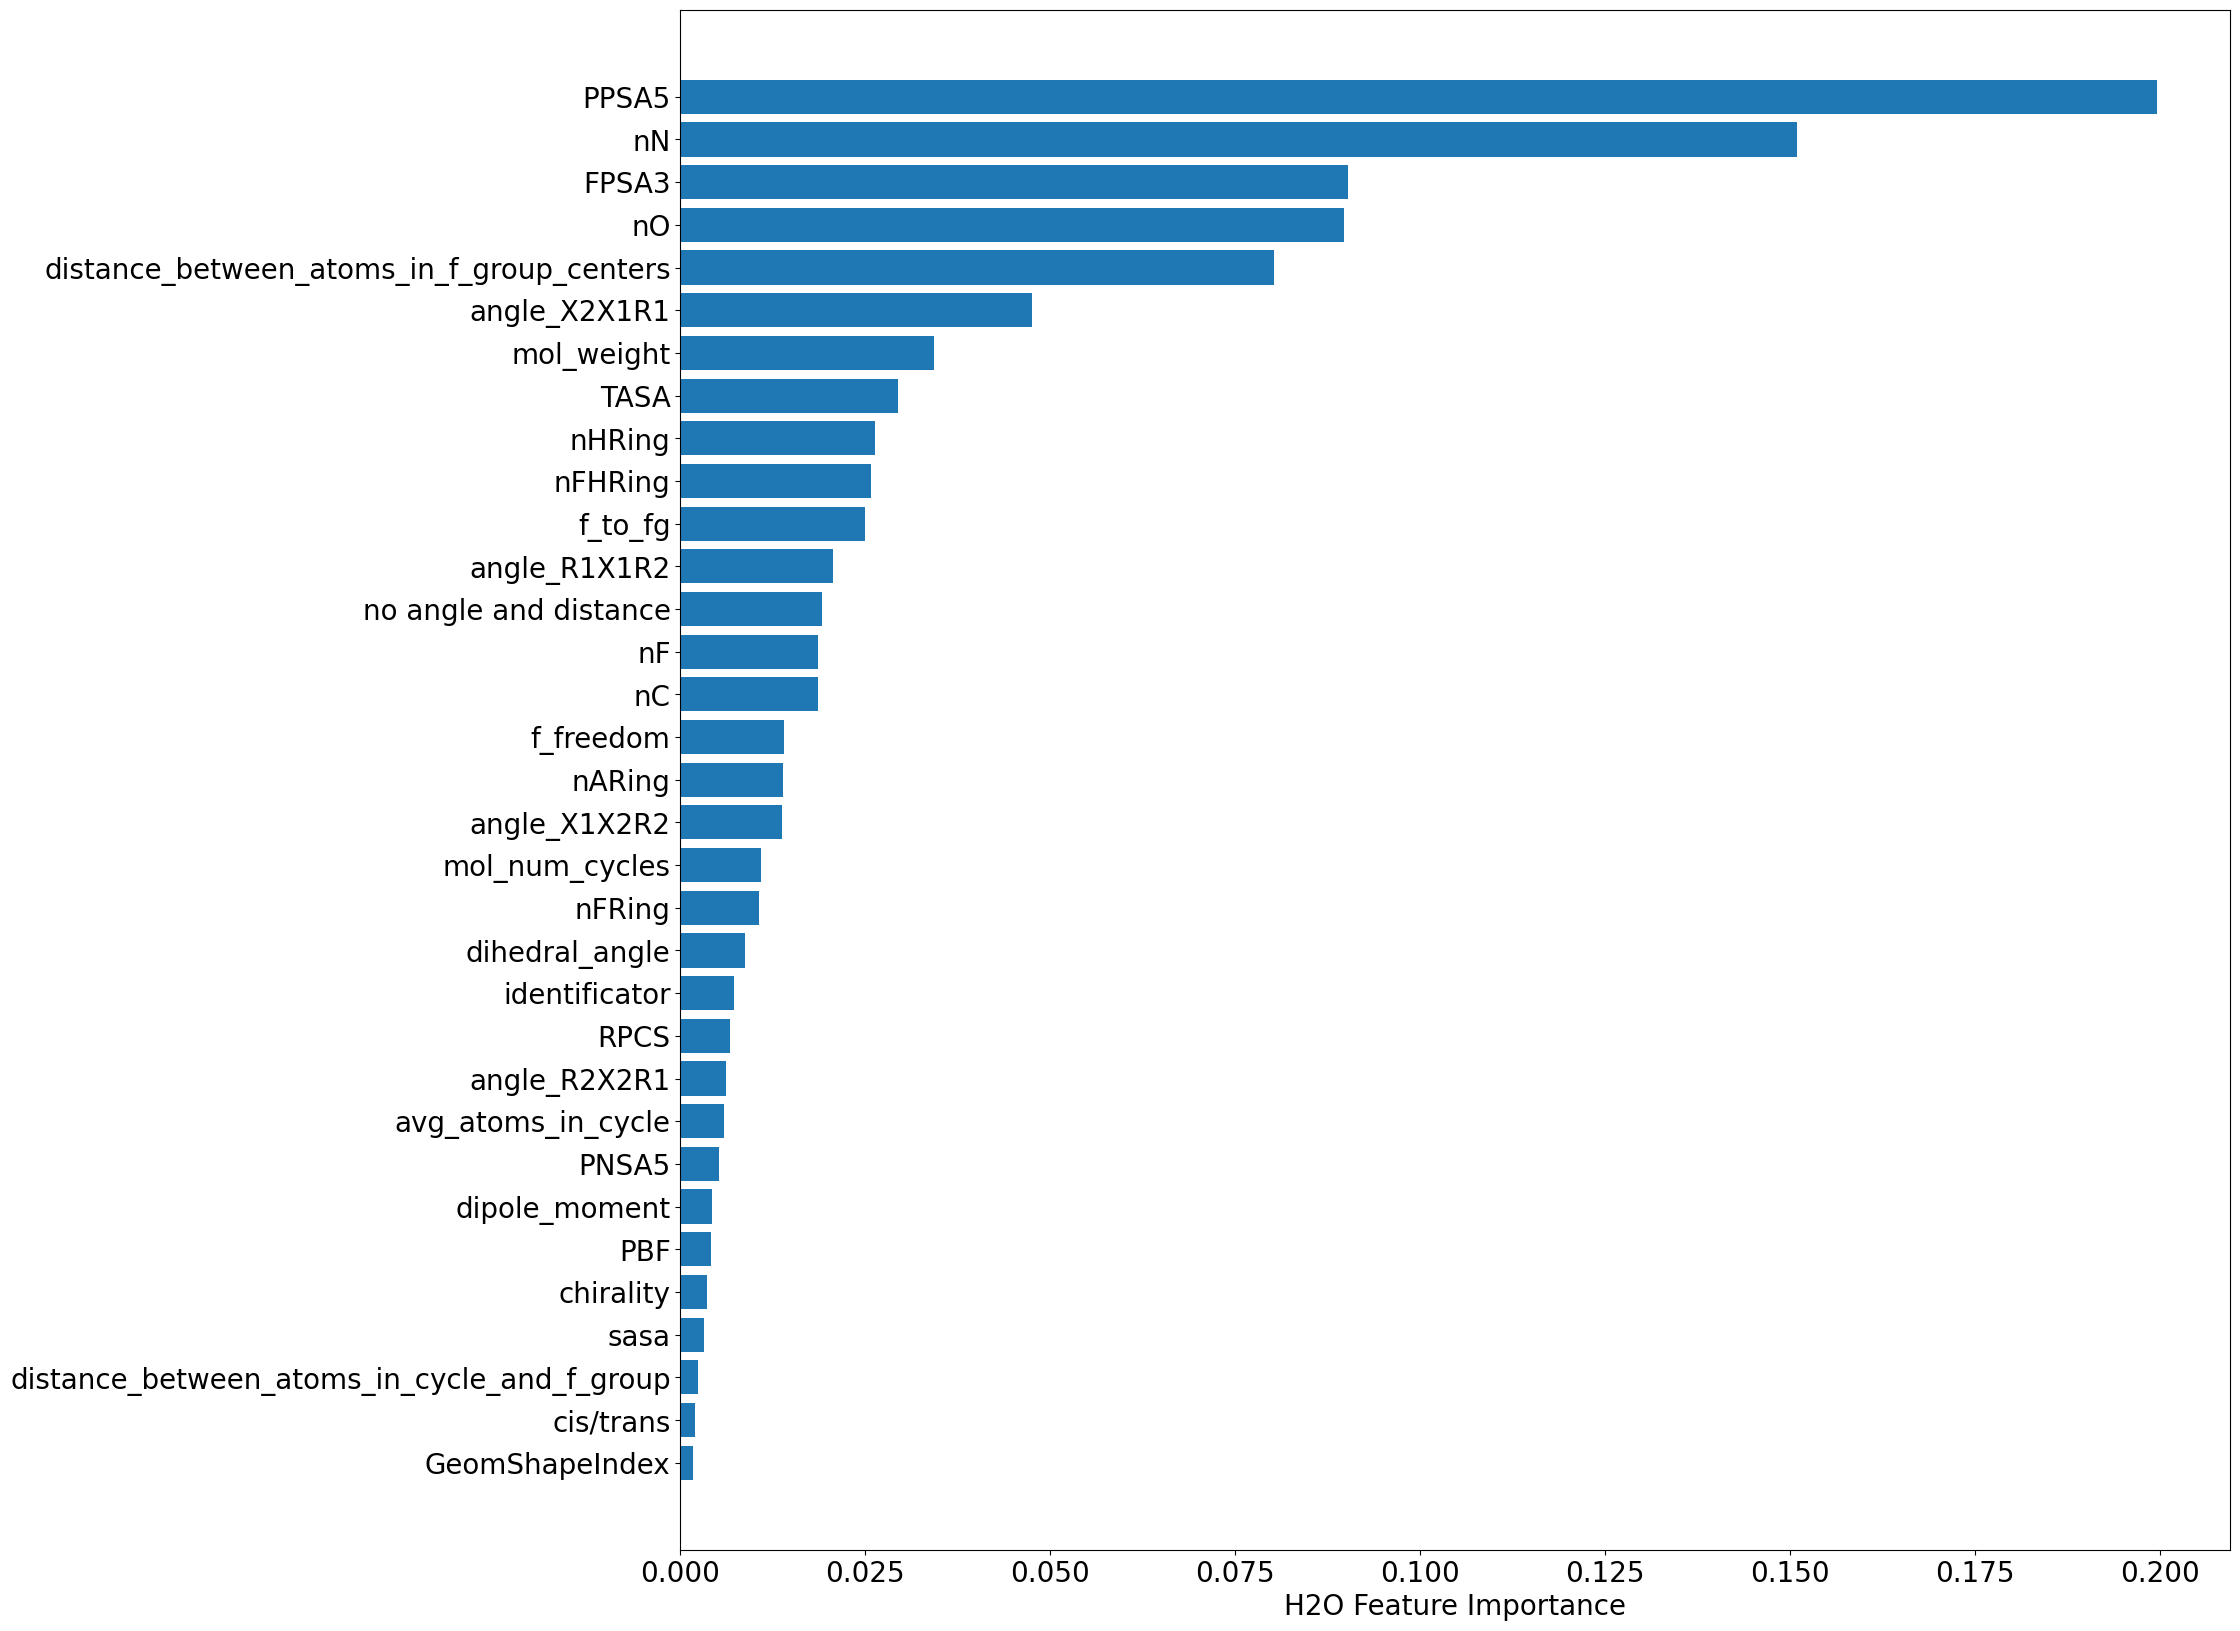

In [17]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

permutation_varimp = best_model.permutation_importance(test, use_pandas=True, n_repeats=1000)

sum_rows = permutation_varimp.sum(axis=1)
sum_rows = sum_rows / sum(sum_rows)

sorted_idx = sum_rows.argsort()
plt.figure(figsize=(20,20))
plt.barh(sum_rows.keys()[sorted_idx][::-1][:][::-1], sum_rows[sorted_idx][::-1][:][::-1])
plt.xlabel("PKa Permutation Importance")

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\38066\AppData\Local\Temp\ipykernel_5036\322070276.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(sum_rows.keys()[sorted_idx][::-1][:10][::-1], sum_rows[sorted_idx][::-1][:10][::-1])


Text(0.5, 0, 'PKa Permutation Importance')

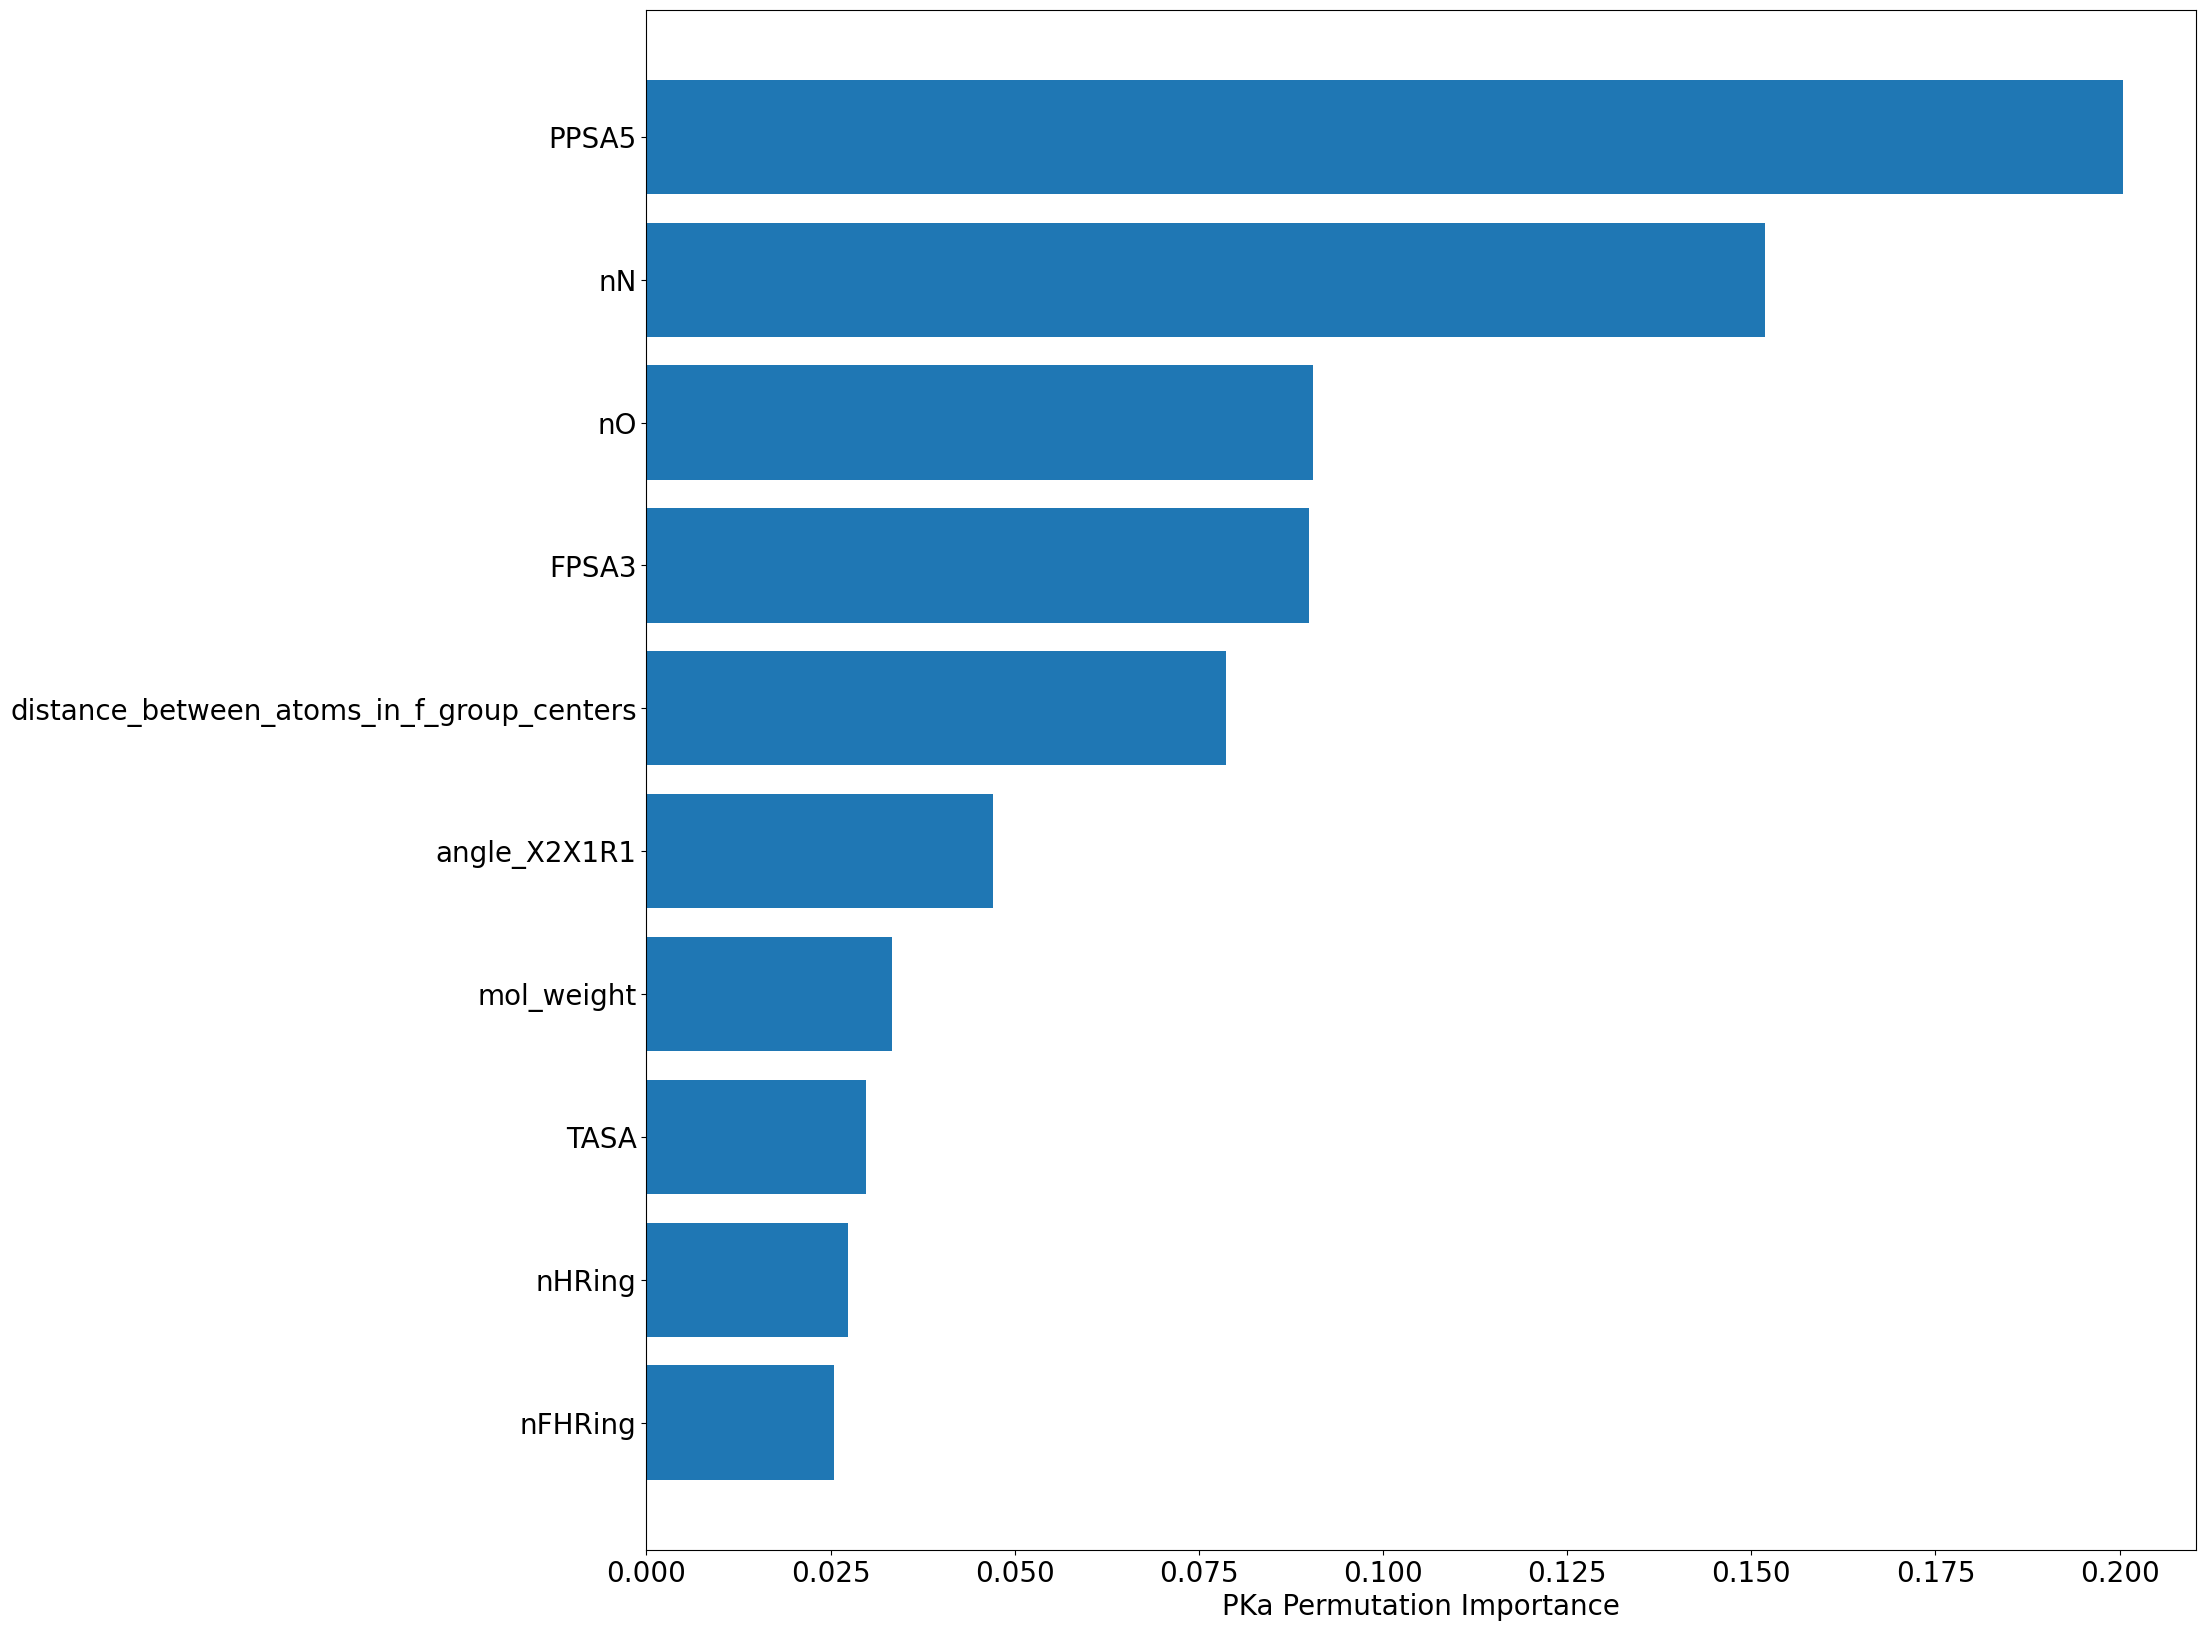

In [20]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

permutation_varimp = best_model.permutation_importance(test, use_pandas=True, n_repeats=1000)

sum_rows = permutation_varimp.sum(axis=1)
sum_rows = sum_rows / sum(sum_rows)

sorted_idx = sum_rows.argsort()
plt.figure(figsize=(20,20))
plt.barh(sum_rows.keys()[sorted_idx][::-1][:10][::-1], sum_rows[sorted_idx][::-1][:10][::-1])
plt.xlabel("PKa Permutation Importance")

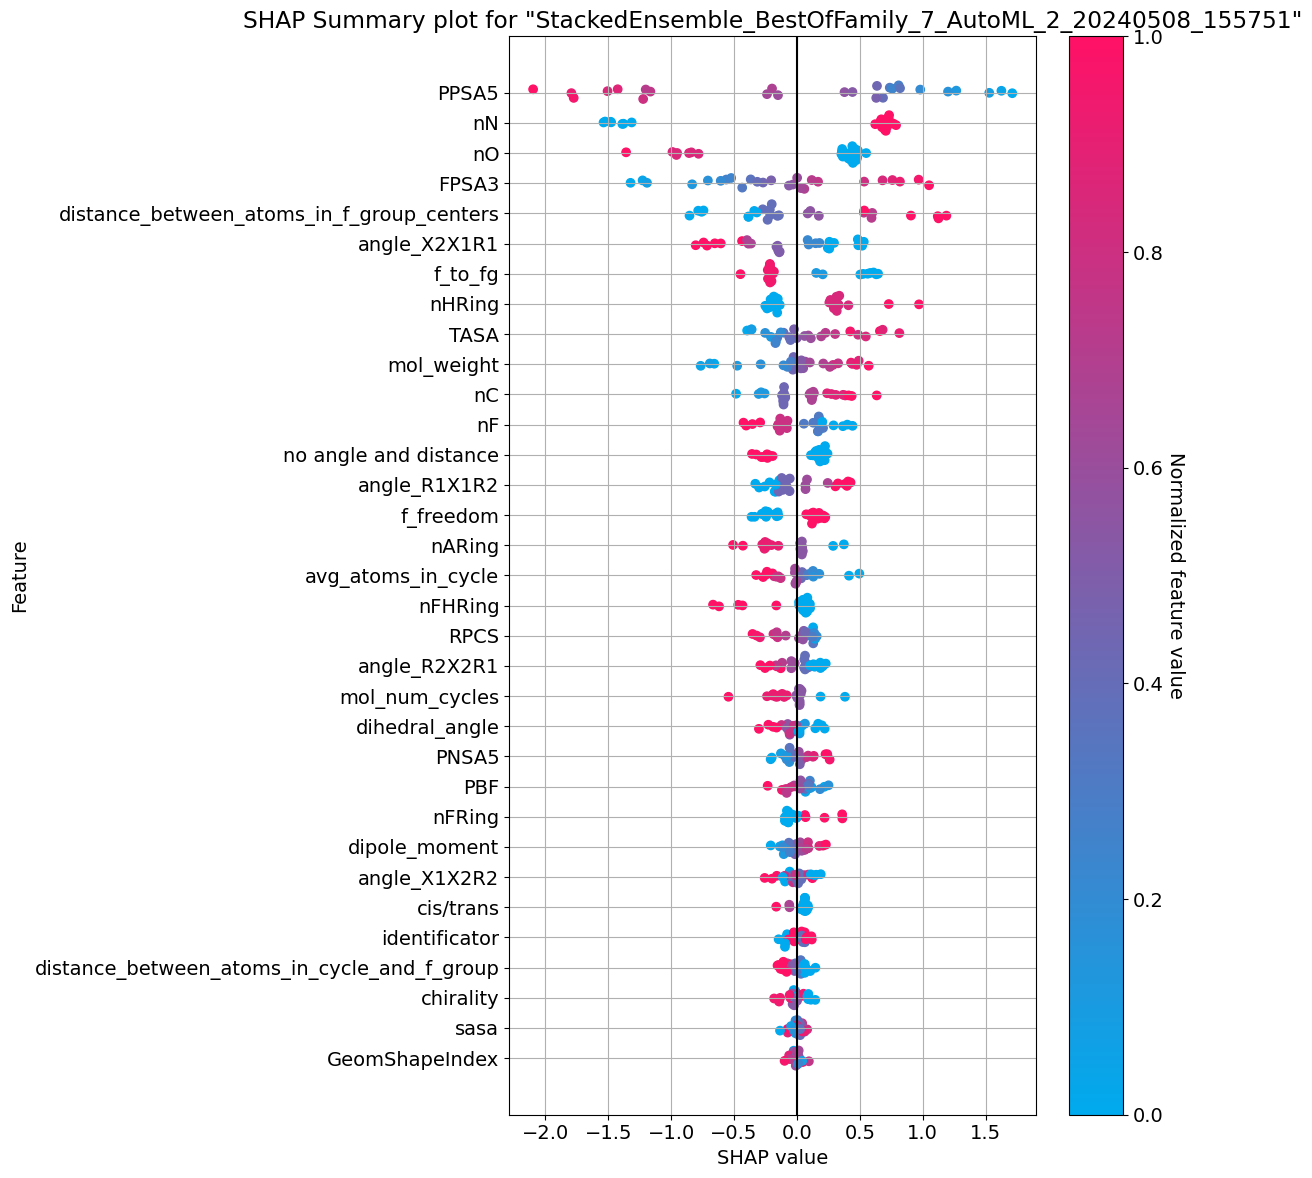

In [21]:
plt.rcParams.update({"font.size": 14})
shap_plot = best_model.shap_summary_plot(test, background_frame=train, top_n_features = 50, samples=1000)

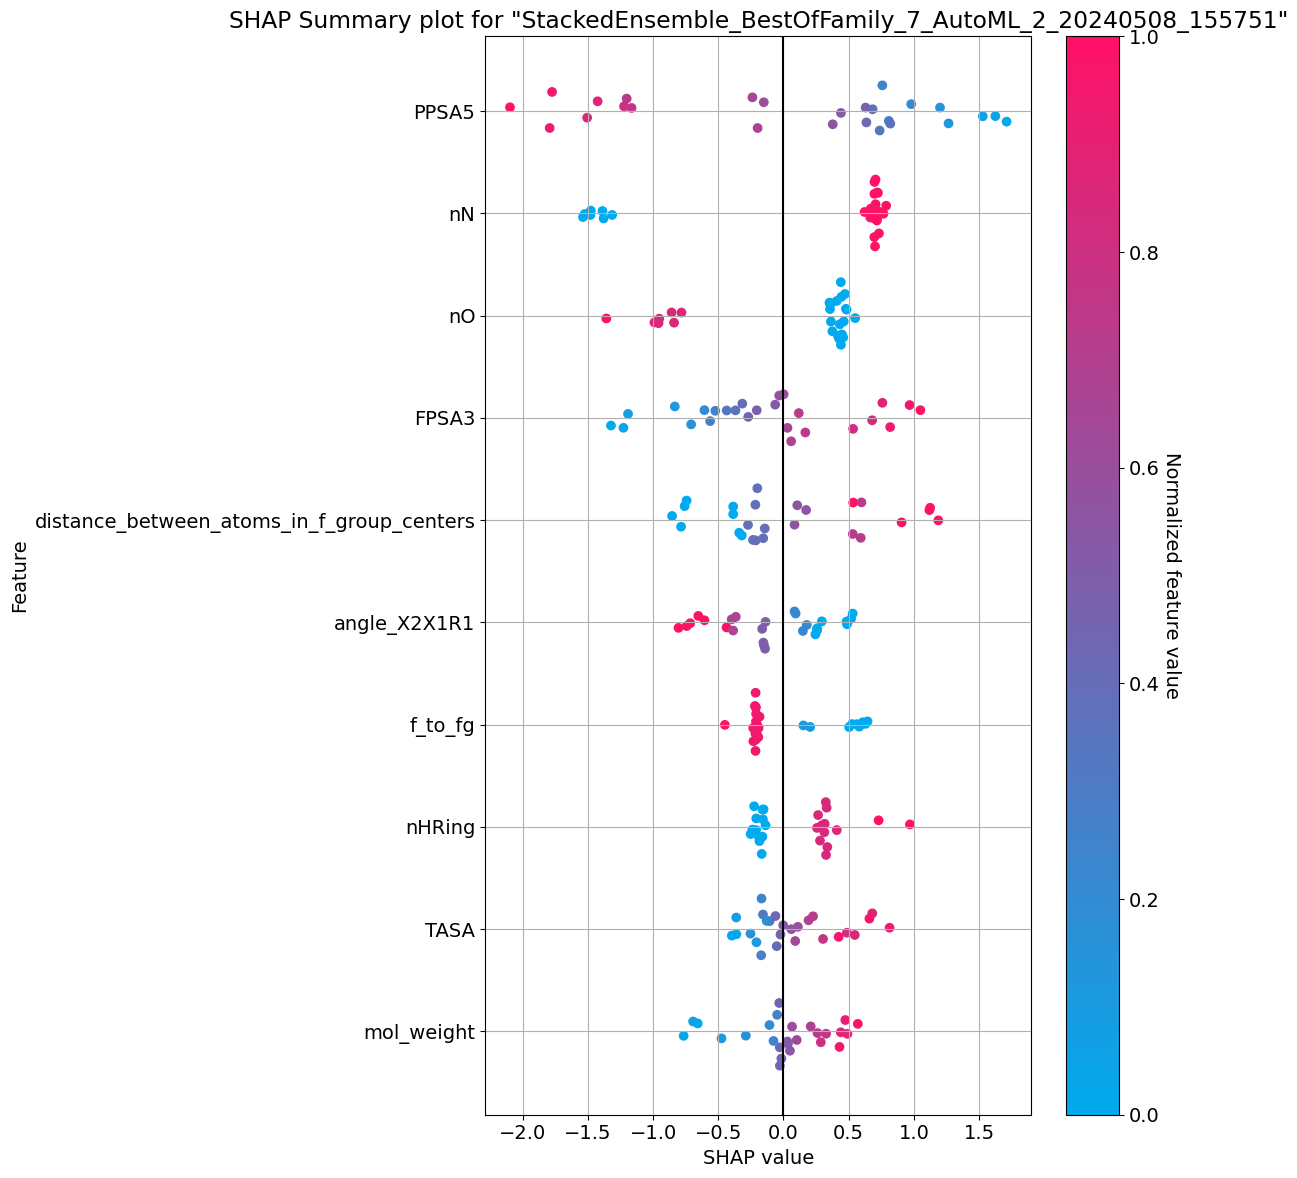

In [22]:
plt.rcParams.update({"font.size": 14})
shap_plot = best_model.shap_summary_plot(test, background_frame=train, top_n_features = 10, samples=1000)

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
DeepLearning_grid_1_AutoML_2_20240508_155751_model_92,0.449656,0.202191,0.374326,0.0522681,0.202191,8576,0.021415,DeepLearning
DeepLearning_grid_3_AutoML_2_20240508_155751_model_34,0.449984,0.202485,0.329367,0.0570968,0.202485,12512,0.036703,DeepLearning
StackedEnsemble_AllModels_6_AutoML_2_20240508_155751,0.470593,0.221458,0.405125,0.0565542,0.221458,481,0.826296,StackedEnsemble
GBM_grid_1_AutoML_2_20240508_155751_model_332,0.473716,0.224406,0.402409,0.0584951,0.224406,178,0.022361,GBM
DeepLearning_grid_3_AutoML_2_20240508_155751_model_10,0.474333,0.224992,0.405224,0.0615395,0.224992,48655,0.034765,DeepLearning
StackedEnsemble_BestOfFamily_6_AutoML_2_20240508_155751,0.474724,0.225363,0.397186,0.0574349,0.225363,226,0.100888,StackedEnsemble
DeepLearning_grid_1_AutoML_2_20240508_155751_model_83,0.475127,0.225746,0.380119,0.0629926,0.225746,8463,0.01443,DeepLearning
GBM_grid_1_AutoML_2_20240508_155751_model_353,0.482615,0.232917,0.366157,0.064829,0.232917,113,0.014903,GBM
DeepLearning_grid_1_AutoML_2_20240508_155751_model_29,0.482905,0.233197,0.3963,0.0579711,0.233197,14897,0.014723,DeepLearning
StackedEnsemble_BestOfFamily_4_AutoML_2_20240508_155751,0.486113,0.236306,0.407605,0.0574793,0.236306,111,0.054557,StackedEnsemble


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

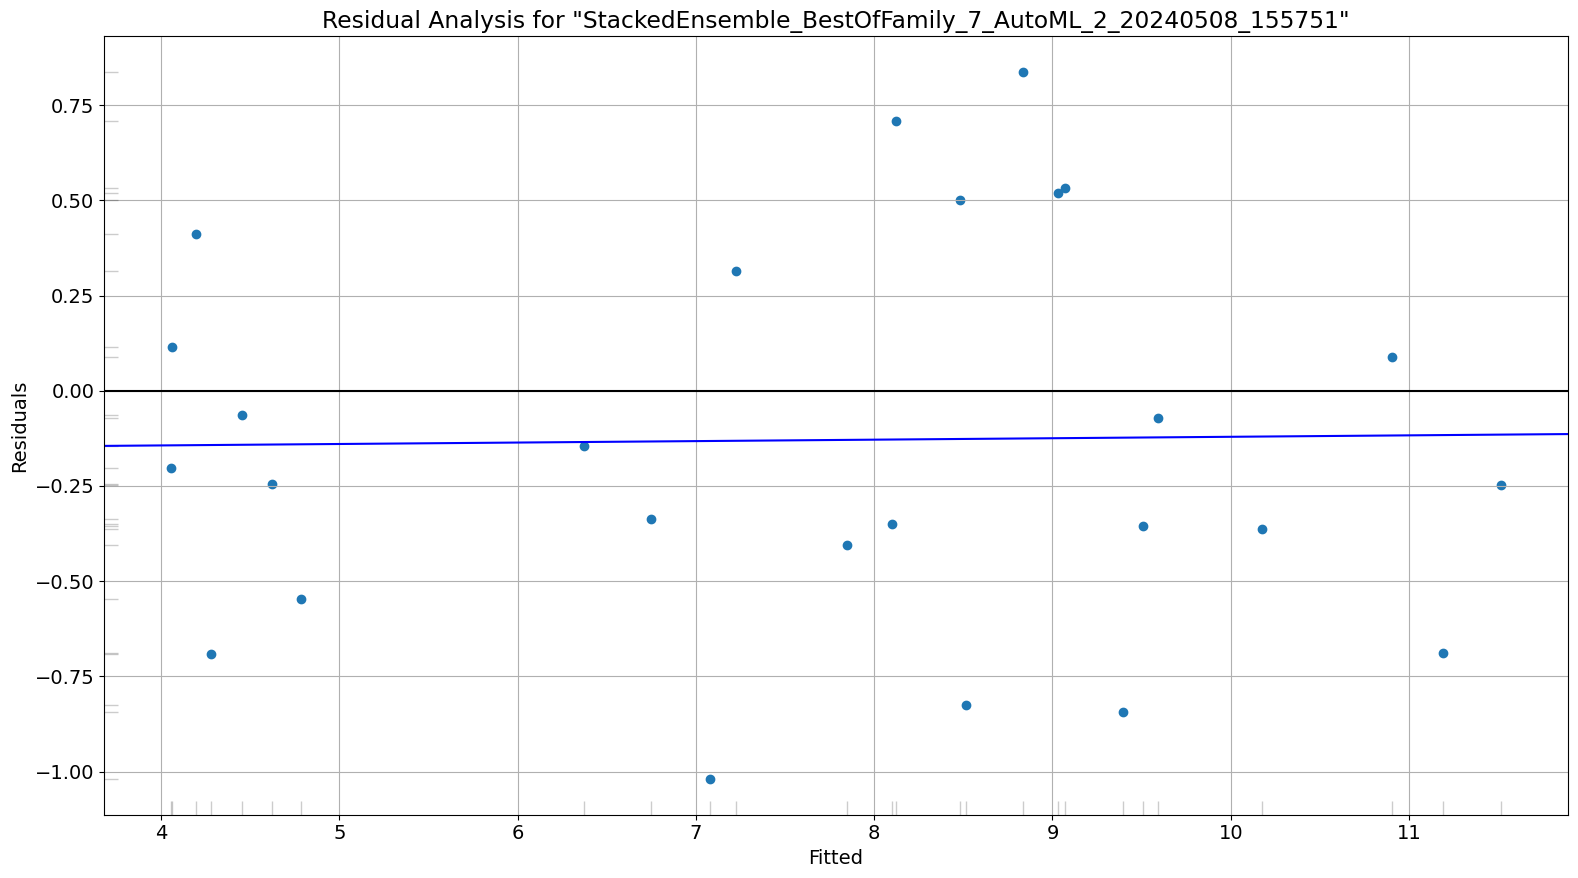

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

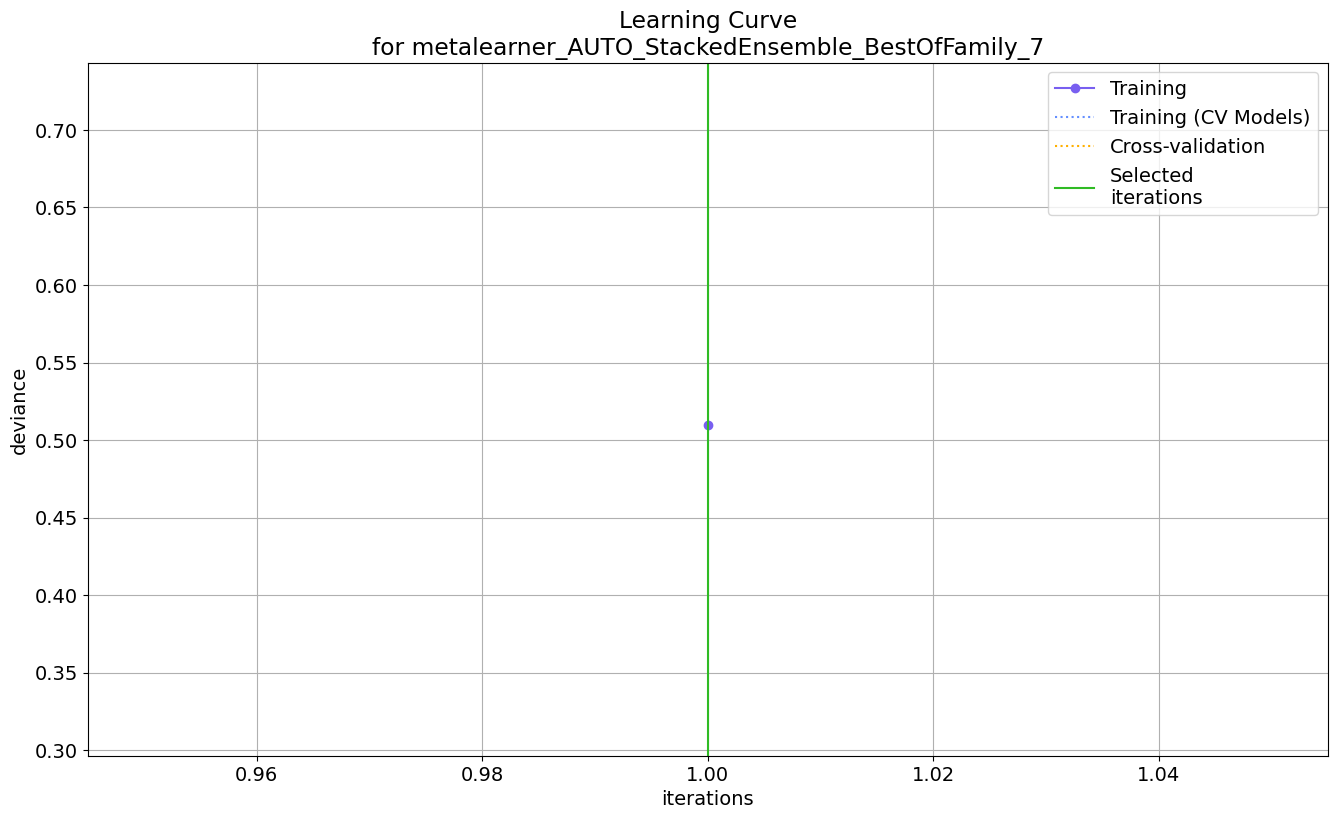

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

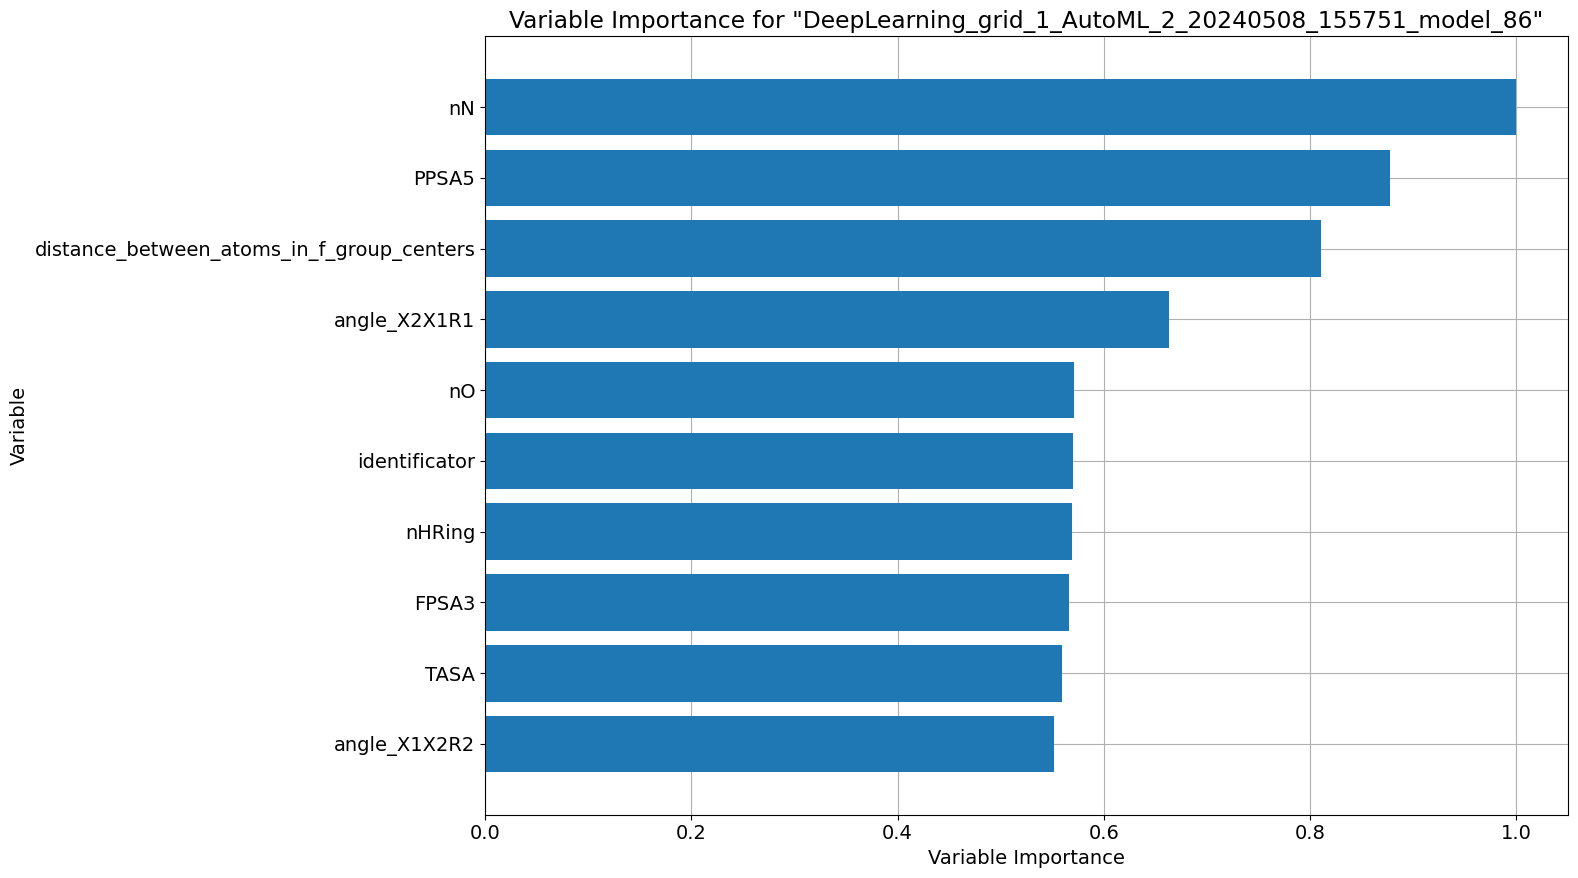

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

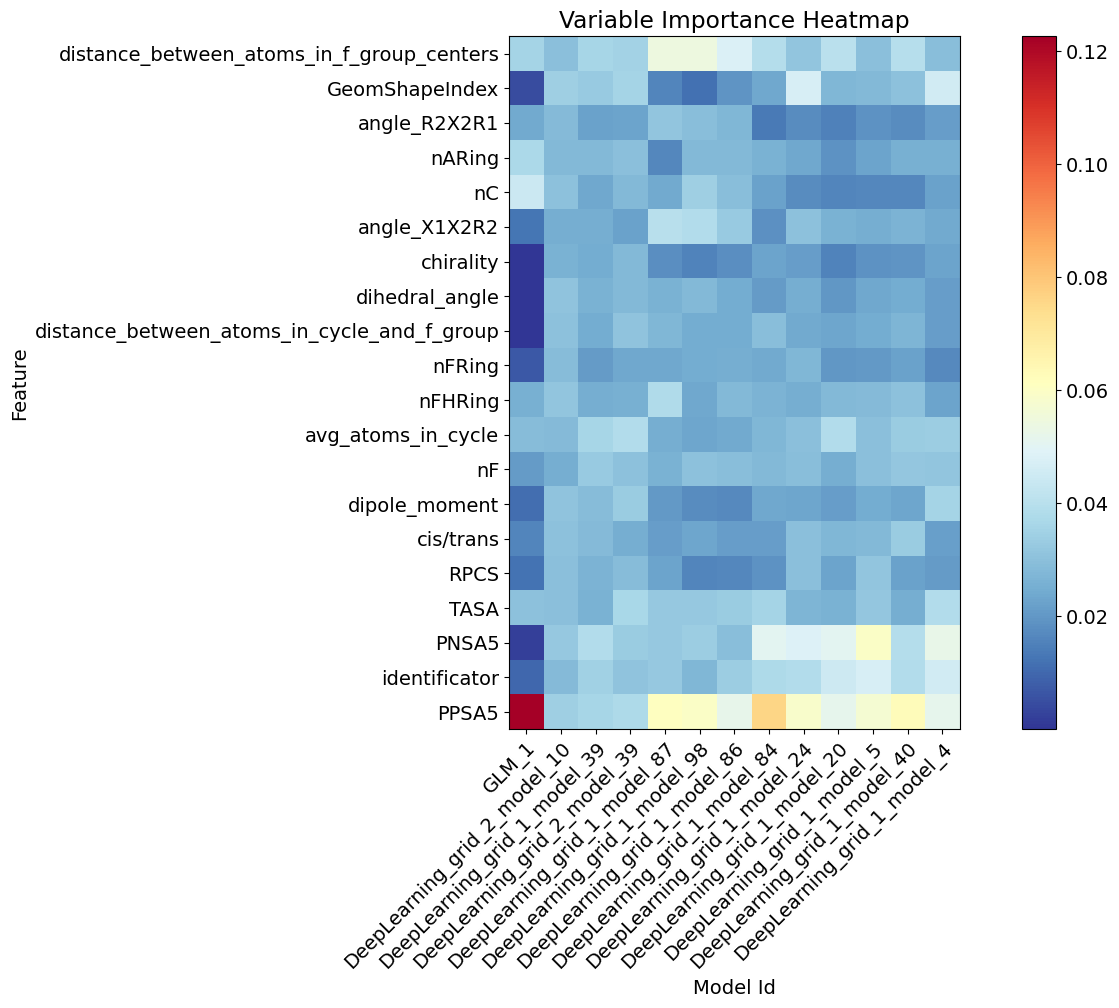

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

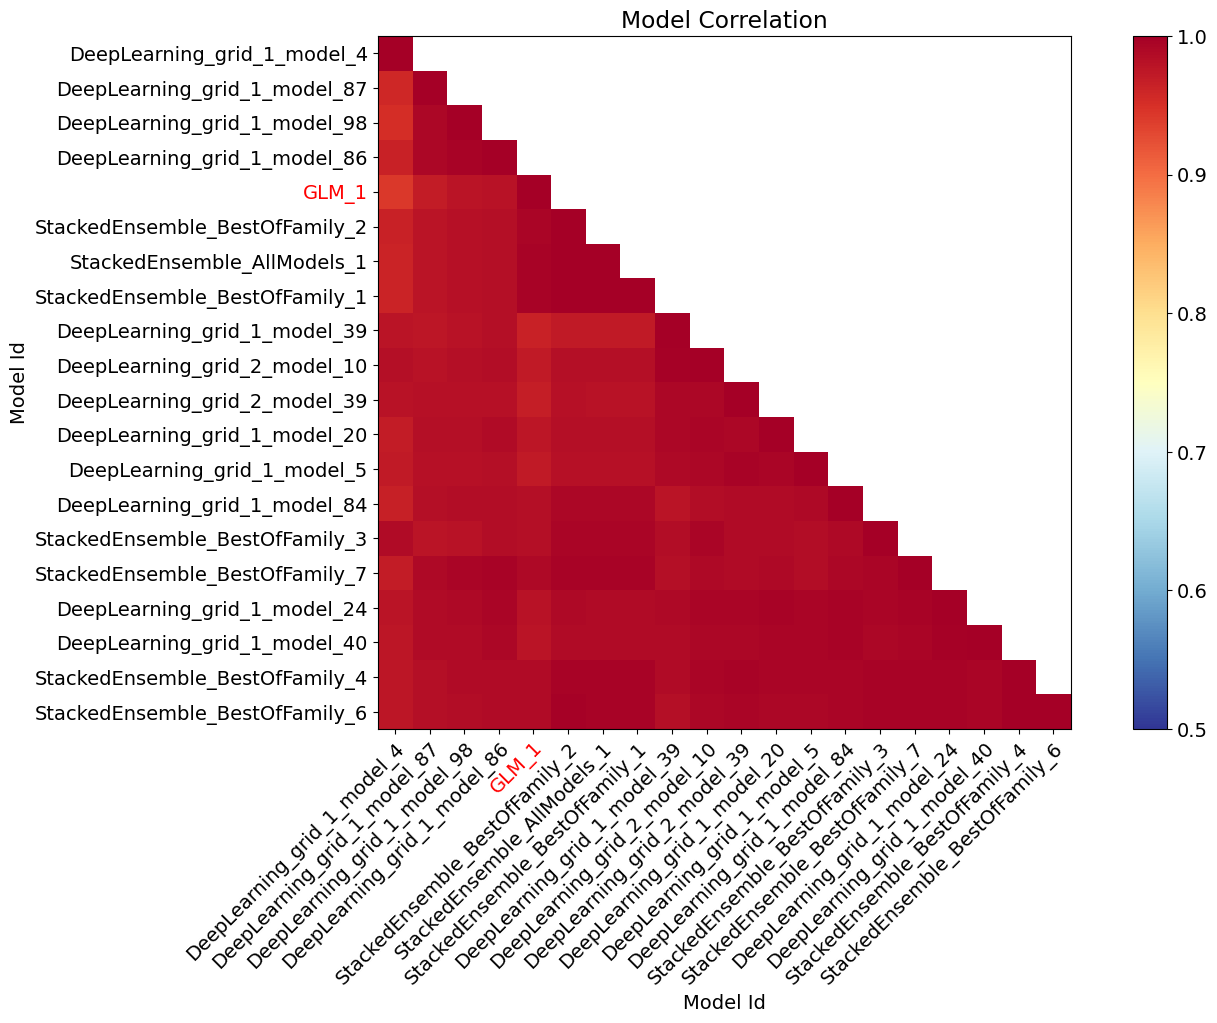

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

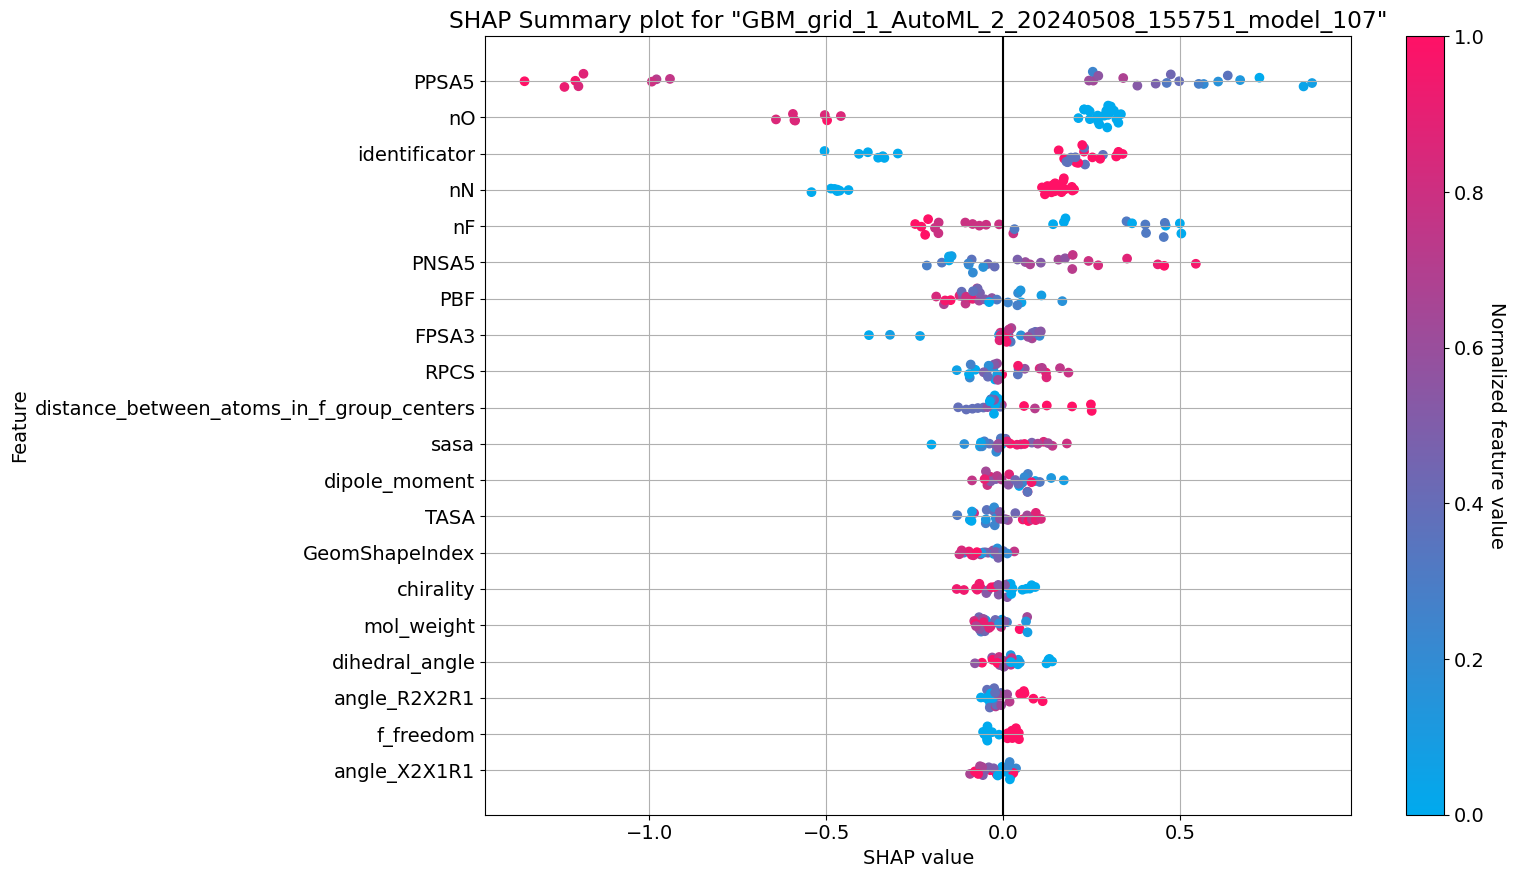

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

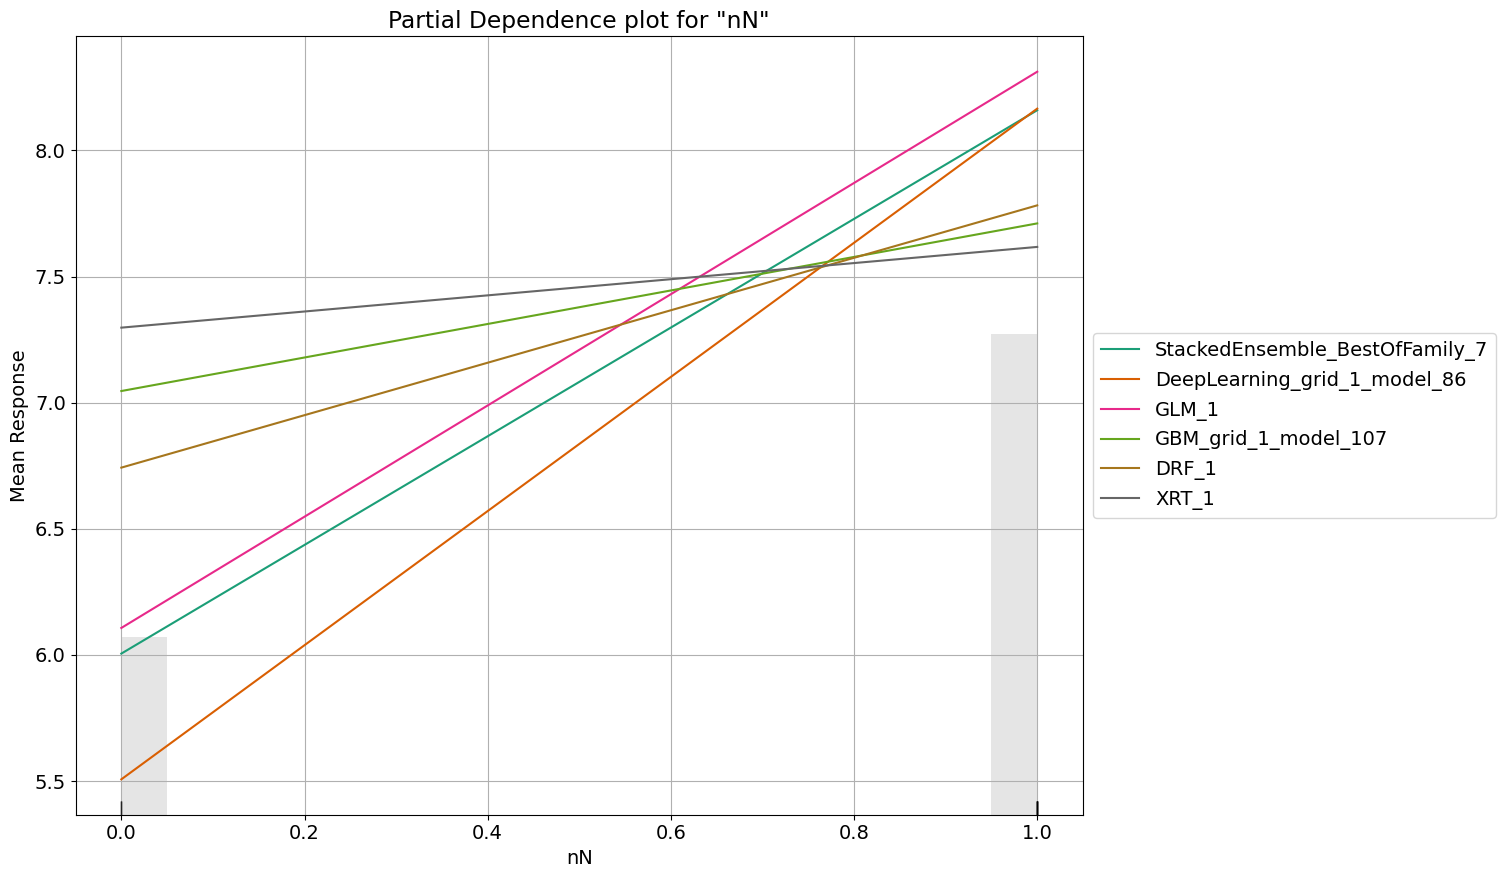

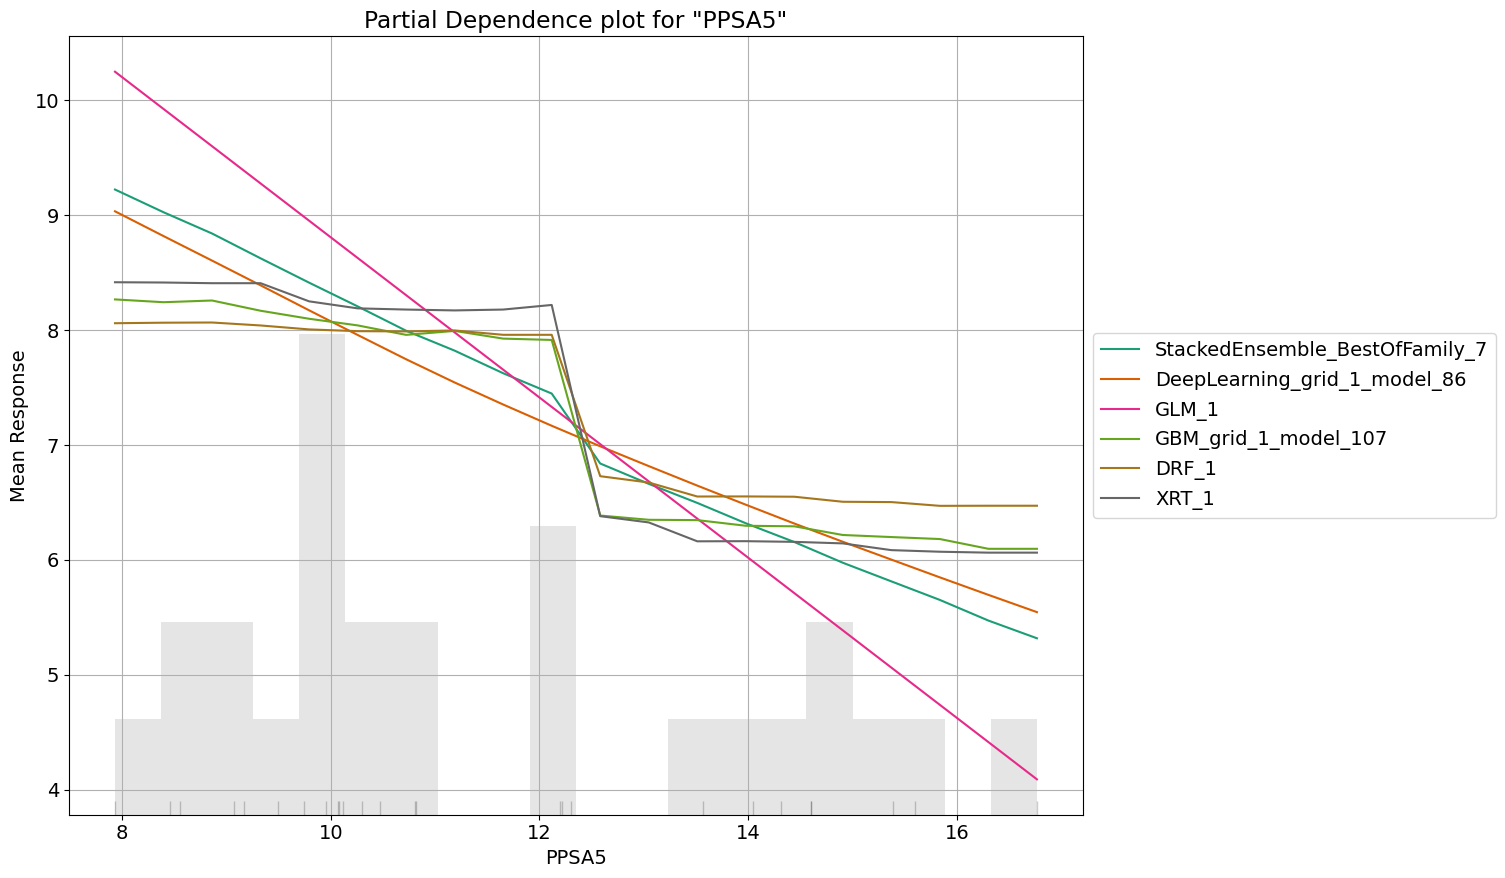

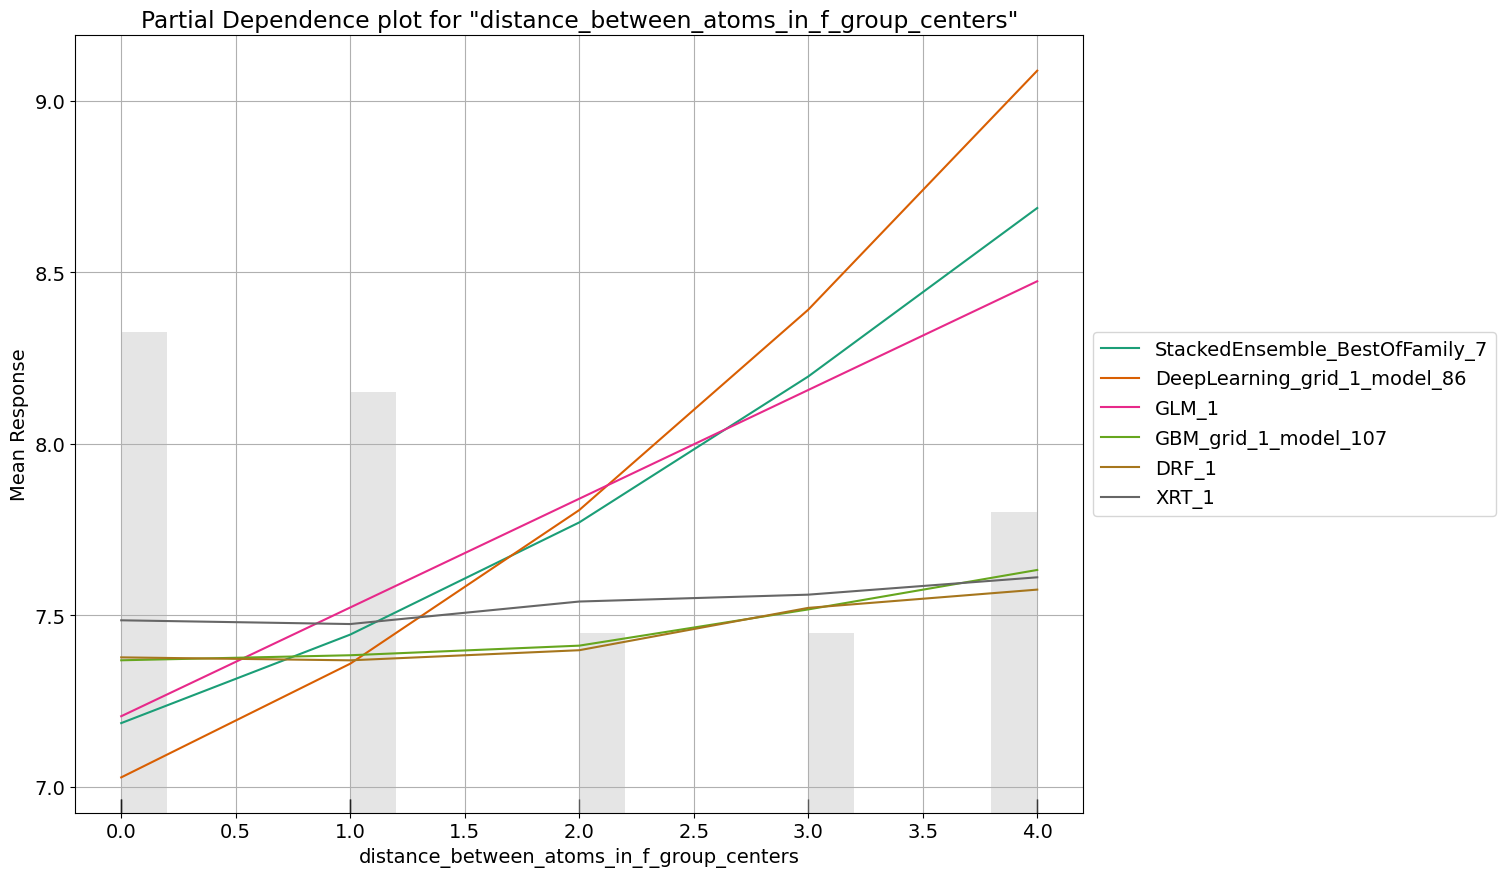

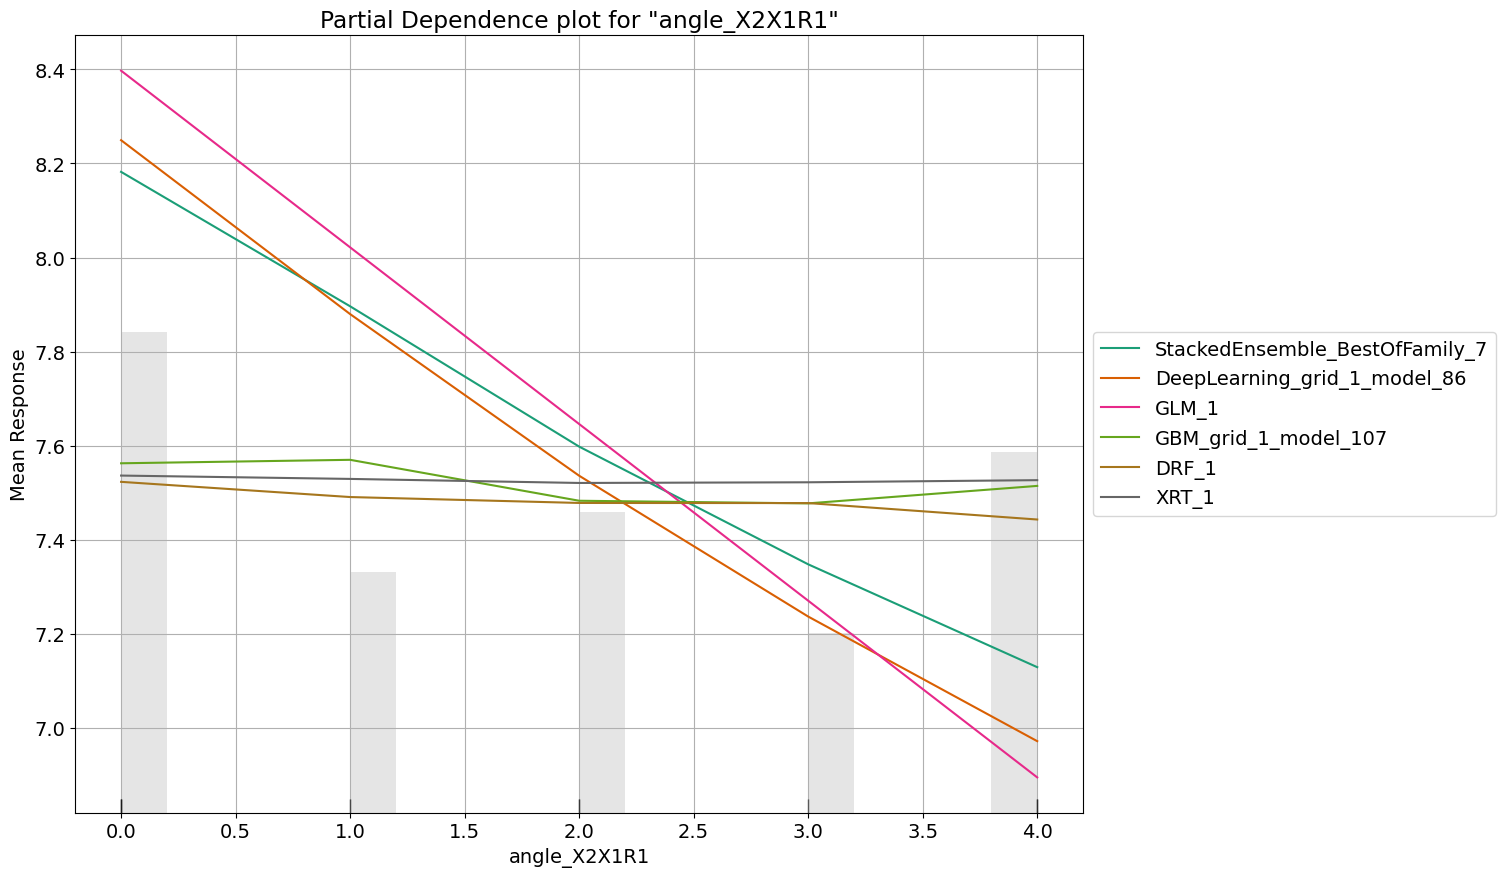

KeyboardInterrupt: 

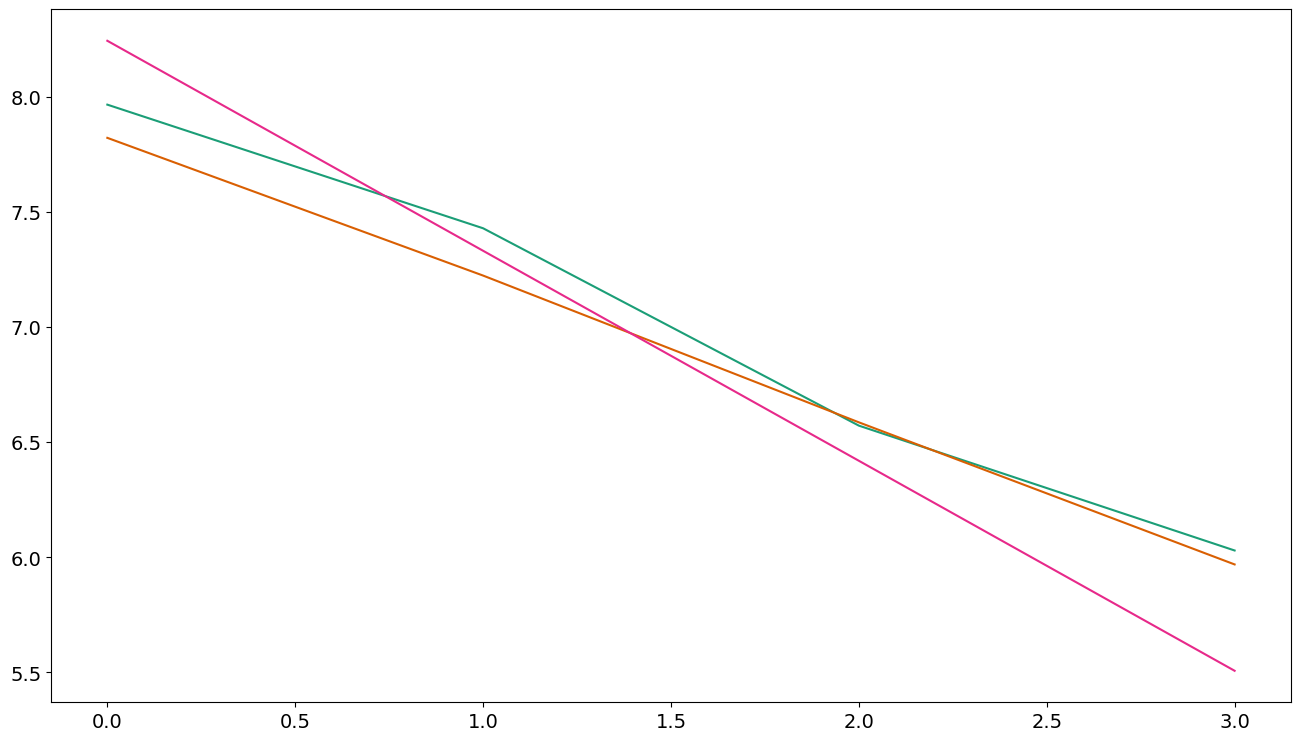

In [19]:
exa = aml.explain(test)

In [26]:
models_list = [
    # stacked models
    h2o.get_model('DeepLearning_grid_1_AutoML_1_20240422_103007_model_98'),
    h2o.get_model('GBM_grid_1_AutoML_1_20240422_103007_model_798'),
    h2o.get_model('DRF_1_AutoML_1_20240422_103007'),
    h2o.get_model('XRT_1_AutoML_1_20240422_103007'),
    h2o.get_model('GLM_1_AutoML_1_20240422_103007'),
    # additional models
    h2o.get_model('GBM_grid_1_AutoML_1_20240422_103007_model_731'),
    h2o.get_model('GBM_grid_1_AutoML_1_20240422_103007_model_950'),
    h2o.get_model('GBM_2_AutoML_1_20240422_103007')
]


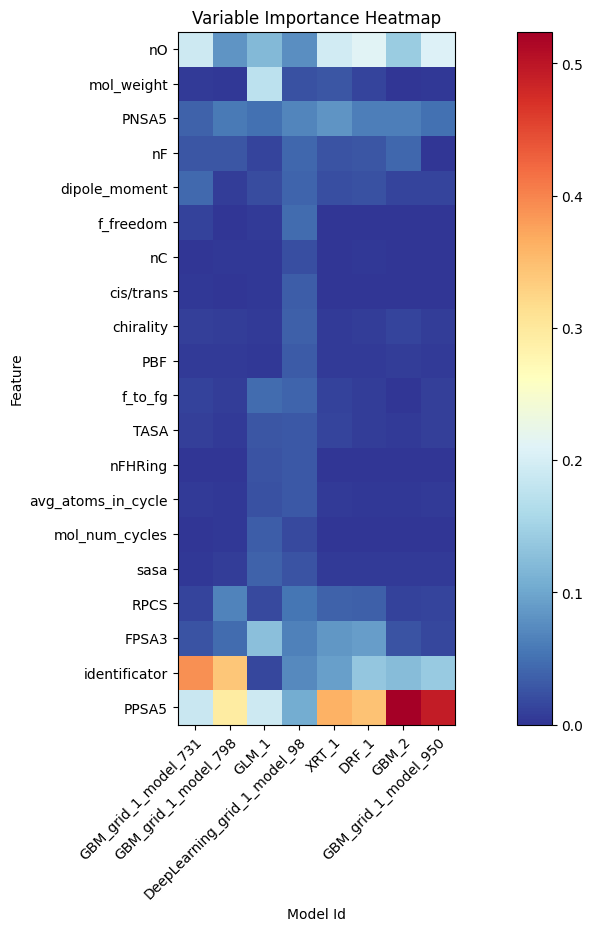

In [27]:
h2o.varimp_heatmap(models_list)

PERMUTATION VALUES

In [3]:
best_model = h2o.load_model(r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\07.05.24\pKa\StackedEnsemble_BestOfFamily_7_AutoML_2_20240508_155751')

In [5]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

permutation_varimp = best_model.permutation_importance(test, use_pandas=True, n_repeats=1000)

sum_rows = permutation_varimp.sum(axis=1)
sum_rows = sum_rows / sum(sum_rows)

print(sum_rows)

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Variable
PPSA5                                          0.200089
nN                                             0.151308
nO                                             0.089881
FPSA3                                          0.090302
angle_X2X1R1                                   0.046709
distance_between_atoms_in_f_group_centers      0.079967
f_to_fg                                        0.024056
nHRing                                         0.027022
nARing                                         0.013744
TASA                                           0.030016
nF                                             0.018136
angle_R1X1R2                                   0.020593
f_freedom                                      0.013634
mol_weight                                     0.034232
mol_num_cycles                                 0.010944
identificator                                  0.007410
nFHRing                                        0.025689
dihedral_angle                         